# What is a pytree?

In [2]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in example_trees:
    leaves = jax.tree_leaves(pytree)
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7fdb897182b0>]   has 3 leaves: [1, 'a', <object object at 0x7fdb897182b0>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


# Why pytrees?

In machine learning, some places where you commonly find pytrees are:

- Model parameters
- Dataset entries
- RL agent observations

They also often arise naturally when working in bulk with datasets (e.g., lists of lists of dicts).

# Common pytree functions

In [4]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

# Example: ML model parameters

In [25]:
import numpy as np

def init_mlp_params(layer_widths):
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,)),
            )
        )
    return params

params = init_mlp_params([1, 256, 256, 256, 256, 256, 1])

In [26]:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (256,), 'weights': (1, 256)},
 {'biases': (256,), 'weights': (256, 256)},
 {'biases': (256,), 'weights': (256, 256)},
 {'biases': (256,), 'weights': (256, 256)},
 {'biases': (256,), 'weights': (256, 256)},
 {'biases': (1,), 'weights': (256, 1)}]

In [27]:
def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):
    
    grads = jax.grad(loss_fn)(params, x, y)
    # Note that 'grads' is a pytree with the same structure as 'params'.
    # 'jax.grad' is one of may JAX junctions that has 
    # built-in support for pytrees
    
    # This is handy, because we can apply the SGD uptdate using tree utils:
    return jax.tree_multimap(
        lambda p, g: p - LEARNING_RATE * g, params, grads
    )

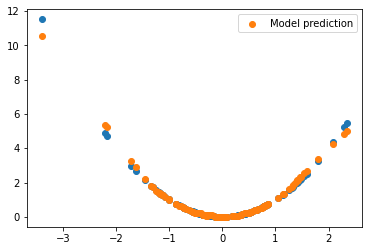

In [28]:
import  matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
    params = update(params, xs, ys)
    
plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend()

# Custom pytree nodes

In [30]:
class MyContainer:
    """A named container."""
    
    def __init__(self, name: str, a: int, b: int, c: int):
        self.name = name
        self.a = a
        self.b = b
        self.c = c

In [31]:
jax.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

In [32]:
jax.tree_map(lambda x: x + 1, [
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

TypeError: unsupported operand type(s) for +: 'MyContainer' and 'int'

To solve this, we need to register our container with JAX by telling it how to flatten and unflatten it:

In [33]:
from typing import Tuple, Iterable

def flatten_MyContainer(container) -> Tuple[Iterable[int], str]:
    """Returns an iterable over container contents, and aux data."""
    flat_contents = [container.a, container.b, container.c]

    # we don't want the name to appear as a child, so it is auxiliary data.
    # auxiliary data is usually a description of the structure of a node,
    # e.g., the keys of a dict -- anything that isn't a node's children.
    aux_data = container.name
    return flat_contents, aux_data

def unflatten_MyContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyContainer:
  """Converts aux data and the flat contents into a MyContainer."""
  return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(
    MyContainer, flatten_MyContainer, unflatten_MyContainer)

jax.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

In [34]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# Since `tuple` is already registered with JAX, and NamedTuple is a subclass,
# this will work out-of-the-box:
jax.tree_leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

# Common pytree gotchas and patterns

## Gotchas
### Mistaking nodes for leaves

In [45]:
a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

# Try to make another tree with ones instead of zeros
shapes = jax.tree_map(lambda x: x.shape, a_tree)
jax.tree_map(jnp.ones, shapes)

[(DeviceArray([1., 1.], dtype=float32),
  DeviceArray([1., 1., 1.], dtype=float32)),
 (DeviceArray([1., 1., 1.], dtype=float32),
  DeviceArray([1., 1., 1., 1.], dtype=float32))]

In [52]:
shapes

[(2, 3), (3, 4)]

In [47]:
jax.tree_leaves(shapes)

[2, 3, 3, 4]

In [48]:
jax.tree_leaves(jnp.array(shapes))

[DeviceArray([[2, 3],
              [3, 4]], dtype=int32)]

In [54]:
a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

# Try to make another tree with ones instead of zeros
shapes = jax.tree_map(lambda x: jnp.array(x.shape), a_tree)
jax.tree_map(jnp.ones, shapes)

[DeviceArray([[1., 1., 1.],
              [1., 1., 1.]], dtype=float32),
 DeviceArray([[1., 1., 1., 1.],
              [1., 1., 1., 1.],
              [1., 1., 1., 1.]], dtype=float32)]

### Handling of None

In [56]:
jax.tree_leaves([None, None, None])

[]

## Patterns
### Transposing trees

In [57]:
def tree_transpose(list_of_trees):
    """Convert a list of trees of identical structure into a single tree of lists"""
    return jax.tree_multimap(lambda *xs: list(xs), *list_of_trees)

# Convert a dataset from row-major to column-major:
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
tree_transpose(episode_steps)

{'obs': [3, 4], 't': [1, 2]}

In [58]:
episode_steps

[{'t': 1, 'obs': 3}, {'t': 2, 'obs': 4}]